In [1]:
import pandas as pd
import numpy as np
import h5py
from pandas import concat
from datetime import datetime
from sklearn.svm import SVR
from keras.layers import Input, Dense, LSTM
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.linear_model import LogisticRegression #logistic regression
import matplotlib.pyplot as plt
import math
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline 

Using TensorFlow backend.


## SVR - Seq2Scalar baseline model

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('merged_final_v2.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('Unnamed: 0', axis=1, inplace=True)
# manually specify column names
dataset.index.name = 'date_1'
# drop the first 24 hours
dataset = dataset[24:]
new_dataset = dataset[['pm2.5','dew_point','air_temp','air_pressure','wind_dir','wind_speed','cumulative_snow_hours','cumulative_rain_hours']]
#drop column wind_dir
new_dataset = new_dataset.drop('wind_dir', 1)
# summarize first 5 rows
print(new_dataset.head(5))


/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                     pm2.5  dew_point  air_temp  air_pressure  wind_speed  \
date_1                                                                      
2010-01-02 00:00:00  129.0        -16      -4.0        1020.0        1.79   
2010-01-02 01:00:00  148.0        -15      -4.0        1020.0        2.68   
2010-01-02 02:00:00  159.0        -11      -5.0        1021.0        3.57   
2010-01-02 03:00:00  181.0         -7      -5.0        1022.0        5.36   
2010-01-02 04:00:00  138.0         -7      -5.0        1022.0        6.25   

                     cumulative_snow_hours  cumulative_rain_hours  
date_1                                                             
2010-01-02 00:00:00                    0.0                    0.0  
2010-01-02 01:00:00                    0.0                    0.0  
2010-01-02 02:00:00                    0.0                    0.0  
2010-01-02 03:00:00                    1.0                    0.0  
2010-01-02 04:00:00                    2.0          

In [3]:
new_dataset.isnull().sum()

pm2.5                    0
dew_point                0
air_temp                 0
air_pressure             0
wind_speed               0
cumulative_snow_hours    0
cumulative_rain_hours    0
dtype: int64

In [4]:
# sorted(new_dataset['pm2.5'].unique(), reverse= True)

In [5]:
#Code referred from Colah's blog
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
values = new_dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 7
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 
# split into train and test sets
values = reframed.values

print(reframed)

(68943, 28)
       var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3       0.129779   0.031431   0.015356   0.003061   0.000179   0.000000   
4       0.148893   0.031528   0.015356   0.003061   0.000268   0.000000   
5       0.159960   0.031915   0.015257   0.003167   0.000357   0.000000   
6       0.182093   0.032302   0.015257   0.003272   0.000536   0.010101   
7       0.138833   0.032302   0.015257   0.003272   0.000625   0.020202   
8       0.109658   0.032302   0.015159   0.003272   0.000714   0.030303   
9       0.105634   0.032302   0.015159   0.003378   0.000893   0.040404   
10      0.124748   0.032302   0.015257   0.003483   0.001072   0.000000   
11      0.120724   0.032205   0.015159   0.003483   0.001251   0.000000   
12      0.132797   0.032302   0.015257   0.003589   0.001430   0.000000   
13      0.140845   0.032302   0.015257   0.003694   0.001743   0.010101   
14      0.152918   0.032205   0.015257   0.003694   0.002056   0.000000   
15      0.148

In [6]:
#Splitting dataset into dev, train and test
n_train_hours = 365* 3 * 24 # 2010 - 2012
n_dev_hours = 365 * 24 # 2013
n_test_hours = 365 *4* 24 # 2014 - 2017
train = values[:n_train_hours, :]
dev = values[n_train_hours:(n_train_hours + n_dev_hours), :]
test = values[(n_train_hours + n_dev_hours):, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
dev_X, dev_y = dev[:, :n_obs], dev[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 

(26280, 21) 26280 (26280,)
(26280, 21) (26280,) (33903, 21) (33903,)


In [7]:
#Running SVR on dev
clf = SVR()
clf.fit(train_X, train_y)

y_pred = clf.predict(dev_X)

dev_y_unscaled = (dev_y * (new_dataset['pm2.5'].max(axis=0) - new_dataset['pm2.5'].min(axis=0))) + new_dataset['pm2.5'].min(axis=0)
y_pred_unscaled = (y_pred * (new_dataset['pm2.5'].max(axis=0) - new_dataset['pm2.5'].min(axis=0))) + new_dataset['pm2.5'].min(axis=0)


rmse = sqrt(mean_squared_error(dev_y_unscaled, y_pred_unscaled))
print('Dev RMSE: %.3f' % rmse)

Dev RMSE: 38.392


In [8]:
# RMSE results on the dev set given time lag values
#1: 36.188
#3: 38.392
#4: 39.626
#6: 41.128
#8: 41.811
#10: 42.156
#15: 43.675
#25  46.108

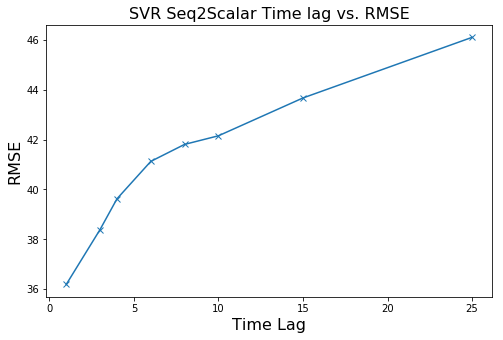

In [9]:
# Numbers below taken from iteratively running above script for dev set
time_lag = [1,3,4,6,8,10,15,25]
rmse_dev = [36.188, 38.392, 39.626, 41.128,41.811, 42.156,43.675,46.108]

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('SVR Seq2Scalar Time lag vs. RMSE', fontsize=16)
ax.set_ylabel('RMSE', fontsize=16)
ax.set_xlabel('Time Lag', fontsize=16)
ax.plot(time_lag, rmse_dev, marker='x')
# plt.axvline(x=30, color='red', linestyle='dashed', linewidth=1)
plt.show()


In [10]:
#Running SVR on test

y_pred_test = clf.predict(test_X)

test_y_unscaled = (test_y * (new_dataset['pm2.5'].max(axis=0) - new_dataset['pm2.5'].min(axis=0))) + new_dataset['pm2.5'].min(axis=0)
y_pred_test_unscaled = (y_pred_test * (new_dataset['pm2.5'].max(axis=0) - new_dataset['pm2.5'].min(axis=0))) + new_dataset['pm2.5'].min(axis=0)


rmse = sqrt(mean_squared_error(test_y_unscaled, y_pred_test_unscaled))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 47.677


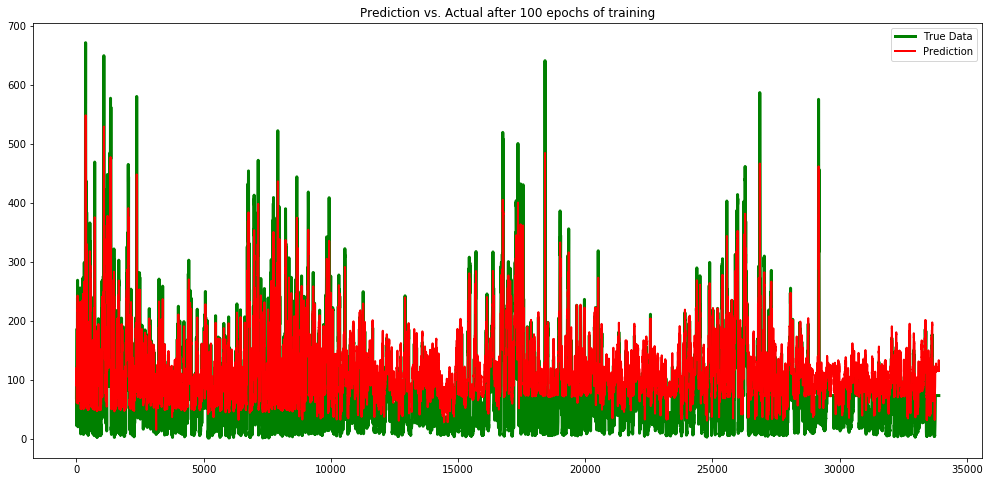

In [11]:
#Plotting the results
def plot_predicted(predicted_data, true_data):
   fig, ax = plt.subplots(figsize=(17,8))
   ax.set_title('Prediction vs. Actual after 100 epochs of training')
   ax.plot(true_data, label='True Data', color='green', linewidth='3')

   ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
   plt.legend()
   plt.show()
    
plot_predicted(y_pred_test_unscaled, test_y_unscaled)

## PCA

In [12]:
new_dataset.head()

,pm2.5,dew_point,air_temp,air_pressure,wind_speed,cumulative_snow_hours,cumulative_rain_hours
date_1,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2.0,0.0


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = new_dataset[['dew_point','air_temp','air_pressure','wind_speed','cumulative_snow_hours','cumulative_rain_hours']].values
X_std = StandardScaler().fit_transform(X);  # standardization of data

# Fit the model with X_std and apply the dimensionality reduction on X_std.
pca = PCA()
Y_pca = pca.fit_transform(X_std)



In [14]:
pca.explained_variance_ratio_

array([ 0.31983113,  0.17368104,  0.16727291,  0.15686143,  0.11673948,
        0.06561402])